# Homework 3: Egyptian Hieroglyphs Classification

In this assignment, you will design and implement two different types of neural networks to classify images of ancient Egyptian hieroglyphs. These models will include:

- **Multi-Layer Perceptron (MLP)**
- **Convolutional Neural Network (CNN)**
- **Fine-Tuned ResNet18**

You will preprocess the dataset, build the models using PyTorch, train and evaluate them, and finally compare their performance.

---

### Dataset: Egyptian Hieroglyphs
We will use the [Egyptian Hieroglyphs dataset on Kaggle](https://www.kaggle.com/datasets/alexandrepetit881234/egyptian-hieroglyphs).

**Description:**
- The dataset contains images of individual Egyptian hieroglyphs.
- Each image is labeled with one of several hieroglyph classes (e.g., animals, symbols).
- The images are of varying sizes but will be resized to **128x128** for model input.
- This is a **multi-class classification problem**.

**Your tasks will include:**
- Preprocessing the data (resizing, normalization, batching)
- Implementing the MLP and CNN architectures based on provided specs
- Writing your own training and evaluation logic
- Comparing the models' performance and discussing the results
- Hyperparameter tuning and evaluation
- Transfer learning implementation, training and testing

**⚠️ Warning:**
- This assignment includes model implementation, training, and hyperparameter tuning, which can be time-consuming depending on your computing resources. Please make sure to allocate at least 3-4 hours to complete it properly.
- Do not modify the structure of the provided code. Complete only the sections marked with "TODO", and write your answers in a new text cell in response to the questions asking explanations.
- You are only required to upload this jupyter notebook, please rename the notebook file as: hw3_yourname_surname.ipynb .

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
from IPython.display import display
import collections
import random
from PIL import Image
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


### Step 1: Load, Visualize and Preprocess the Dataset
In this section, we begin by preparing the dataset for training. We define a series of image transformations, including resizing, tensor conversion, and normalization. The dataset is then loaded and organized into training, validation, and test sets using PyTorch’s ImageFolder and DataLoader. Finally, we visualize random samples and plot the class distribution to better understand the data and ensure balanced representation across classes.

In [85]:
# Define transforms
transform = transforms.Compose([
    # Resize the images to 128x128
    transforms.Resize((128, 128)),
    # Convert the images to tensors
    transforms.ToTensor(),
    # Normalize the pixel values to the range [-1, 1]
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dir = 'archive/train'
valid_dir = 'archive/valid'
test_dir  = 'archive/test'

# Create the train, validation, and test datasets
train_dataset = ImageFolder(train_dir, transform=transform)
valid_dataset = ImageFolder(valid_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

# Create data loaders for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the classes in the train dataset
print("Classes:", train_dataset.classes)


Classes: ['among', 'branch', 'divide', 'elephant', 'eye', 'fish', 'flail', 'foot', 'galena', 'leg', 'life', 'loaf', 'man', 'one', 'papyrus', 'soldier', 'stick', 'swallow', 'turtle', 'water']


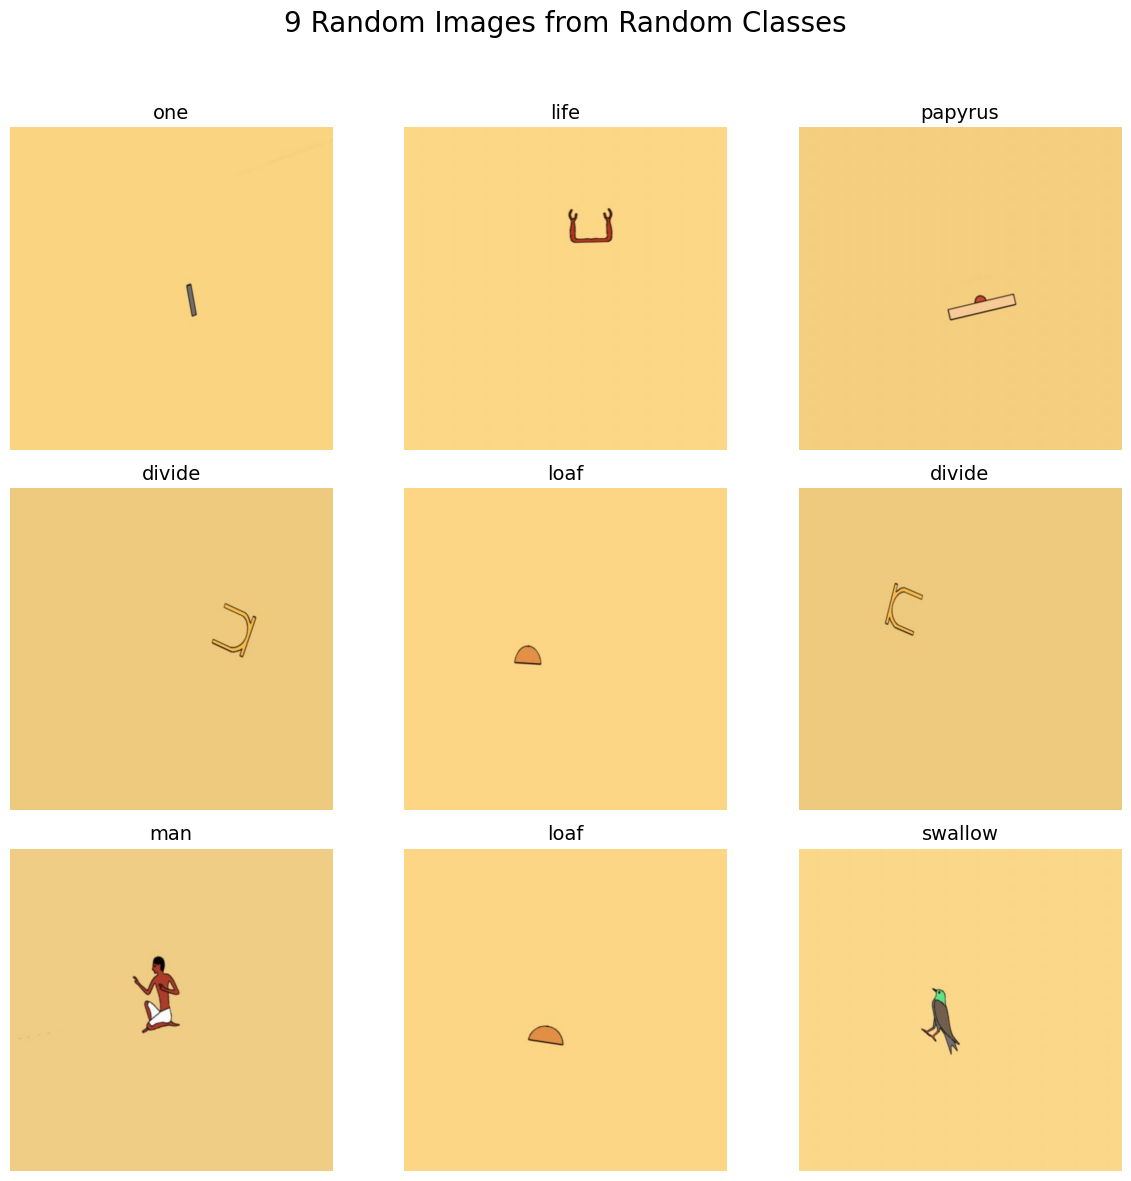

In [86]:
# Randomly sample 9 images from the training dataset
sample_indices = random.sample(range(len(train_dataset.samples)), 9)
samples = [train_dataset.samples[i] for i in sample_indices]

# Create a 3x3 grid for the images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('9 Random Images from Random Classes', fontsize=20)

#Show the images
for ax, (img_path, label) in zip(axes.flatten(), samples):
    img = Image.open(img_path).convert("RGB")
    ax.imshow(img)
    # Get class name
    ax.set_title(train_dataset.classes[label], fontsize=14)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


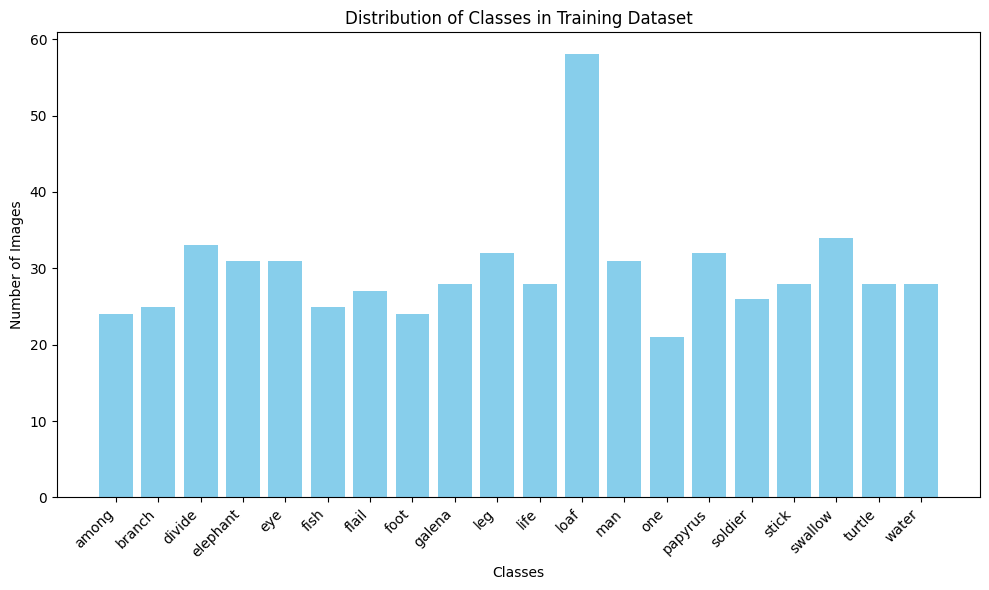

In [87]:
# Count the number of images per class
labels = [label for _, label in train_dataset.samples]
class_counts = collections.Counter(labels)

# Map class names
class_names = [train_dataset.classes[label] for label in class_counts.keys()]
counts = list(class_counts.values())

# Create a bar plot to visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Training Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Step 2: Implement an MLP [15 pts]

You will implement a **Multi-Layer Perceptron (MLP)** to classify the Egyptian hieroglyph images. An MLP is a type of fully connected neural network that processes flattened input data.

---

#### Architecture Overview

1. **Input Layer**  
   - Flattened image: `128 x 128 = 16384` features

2. **Hidden Layer 1**  
   - `in_features=16384`, `out_features=1024`  
   - ReLU 

3. **Hidden Layer 2**  
   - `in_features=1024`, `out_features=512`  
   - ReLU 

4. **Hidden Layer 3**  
   - `in_features=512`, `out_features=128`  
   - ReLU

5. **Output Layer**  
   - `in_features=128`, `out_features=20`
---

**Your task:**  
Implement this architecture in the `MLP` class using `nn.Linear` and `nn.ReLU`. Remember to flatten the input before passing it through the layers.

In [88]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Define layers (e.g., Linear -> ReLU -> Linear -> ReLU -> Output)
        self.layers = nn.Sequential(
            nn.Linear(in_features=128*128*3, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=20)
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self.layers(x)


### Step 3: Implement a CNN [20pts]

Now, you will implement a **Convolutional Neural Network (CNN)** to classify the Egyptian hieroglyph images. CNNs are well-suited for image tasks as they capture spatial patterns through convolution and pooling.

---

#### Architecture Overview

1. **Conv Layer 1**  
   - `in_channels=3`, `out_channels=32`, `kernel_size=3`, `padding=1`  
   - BatchNorm → ReLU → MaxPool(2)

2. **Conv Layer 2**  
   - `in_channels=32`, `out_channels=64`, `kernel_size=3`, `padding=1`  
   - BatchNorm → ReLU → MaxPool(2)

3. **Conv Layer 3**  
   - `in_channels=64`, `out_channels=128`, `kernel_size=3`, `padding=1`  
   - BatchNorm → ReLU → MaxPool(2)

4. **Flatten**

5. **Fully Connected Layer 1**  
   - `in_features=?`, `out_features=256`  
   - ReLU → Dropout(0.5)

6. **Output Layer**  
   - `in_features=256`, `out_features=20`

---

**Your task:**  
Complete the `CNN` class using PyTorch layers. Make sure the dimensions between layers match properly.

In [89]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # define layers as per spec
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), 

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Flatten(),            
            nn.Linear(128 * 16 * 16, 256), # 32768 to 256
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 20)
        )



    def forward(self, x):
        y = self.layers(x)
        return y


### Step 4: Training Loop Template [15 pts]
In this step, you'll complete the training loop that updates the model using the training set and evaluates it on a validation set.
For each epoch:
- Train the model using `train_loader`
- Evaluate its performance using `valid_loader`
- Track both training and validation loss
Use `model.train()` during training and `model.eval()` for validation. Return both loss lists for visualization.
Fill in the `TODO` parts in the function below to complete the training logic.

In [90]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs):
    model.to(device)
    train_losses = []
    val_losses = []
    

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # zero gradients
            optimizer.zero_grad()
            # forward pass
            outputs = model(inputs)
            # compute loss
            loss = criterion(outputs, targets)
            # backward pass
            loss.backward()
            # optimizer step
            optimizer.step()
            # accumulate loss
            total_train_loss += loss.item()
            
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)        
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(valid_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

### Step 5: Evaluation
In this step, you will evaluate the model's performance on the test set.
The evaluation function:
- Computes overall **accuracy**
- Generates a **classification report** (precision, recall, F1-score) as a table
- Displays a **confusion matrix** with annotated counts
This step helps you understand how well the model performs across different classes.

In [91]:
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    accuracy = 100 * correct / total
    print(f"Accuracy on test set: {accuracy:.2f}%")

    # Metrics
    num_classes = len(set(all_targets))
    class_names = [str(i) for i in range(num_classes)]

    # Print precision, recall, f1
    print("\nClassification Report:")

    report_dict = classification_report(all_targets, all_preds, target_names=class_names, output_dict=True)

    report_df = pd.DataFrame(report_dict).transpose()

    display(report_df)

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds, labels=range(num_classes))

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # Annotate confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                     ha='center', va='center',
                     color='white' if cm[i, j] > thresh else 'black')

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    return accuracy



Training MLP...
Epoch 1/50, Train Loss: 3.0281, Val Loss: 3.0442
Epoch 2/50, Train Loss: 2.9599, Val Loss: 3.0066
Epoch 3/50, Train Loss: 2.8912, Val Loss: 2.9504
Epoch 4/50, Train Loss: 2.7843, Val Loss: 2.8489
Epoch 5/50, Train Loss: 2.6555, Val Loss: 2.7896
Epoch 6/50, Train Loss: 2.5429, Val Loss: 2.6066
Epoch 7/50, Train Loss: 2.3756, Val Loss: 2.4215
Epoch 8/50, Train Loss: 2.2742, Val Loss: 2.3483
Epoch 9/50, Train Loss: 2.1886, Val Loss: 2.2602
Epoch 10/50, Train Loss: 2.1009, Val Loss: 2.2286
Epoch 11/50, Train Loss: 2.0531, Val Loss: 2.1917
Epoch 12/50, Train Loss: 2.0132, Val Loss: 2.0447
Epoch 13/50, Train Loss: 1.9713, Val Loss: 2.0673
Epoch 14/50, Train Loss: 1.9556, Val Loss: 1.9562
Epoch 15/50, Train Loss: 1.8718, Val Loss: 2.0150
Epoch 16/50, Train Loss: 1.8709, Val Loss: 2.0079
Epoch 17/50, Train Loss: 1.9140, Val Loss: 1.9889
Epoch 18/50, Train Loss: 1.8188, Val Loss: 1.8859
Epoch 19/50, Train Loss: 1.8491, Val Loss: 1.8853
Epoch 20/50, Train Loss: 1.8457, Val Loss:

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,8.00000
1,0.333333,0.666667,0.444444,3.00000
2,0.000000,0.000000,0.000000,3.00000
3,0.000000,0.000000,0.000000,1.00000
4,0.000000,0.000000,0.000000,2.00000
5,0.000000,0.000000,0.000000,4.00000
6,0.363636,0.800000,0.500000,5.00000
7,0.000000,0.000000,0.000000,6.00000
8,0.000000,0.000000,0.000000,8.00000
9,0.066667,0.333333,0.111111,3.00000


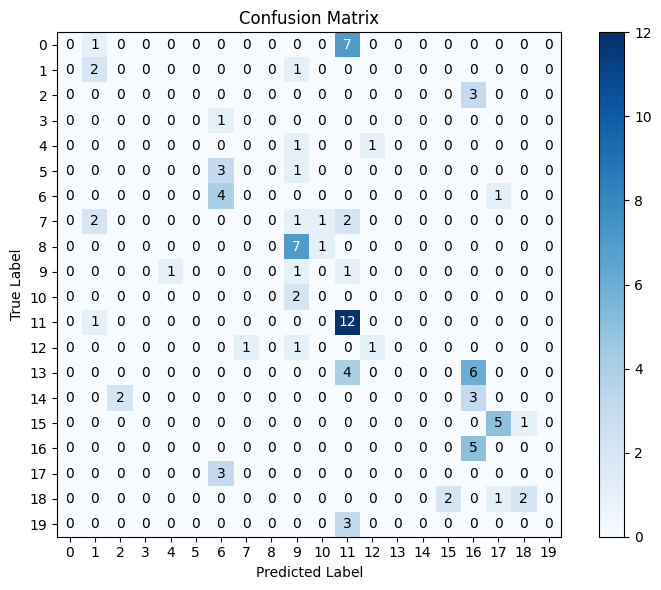

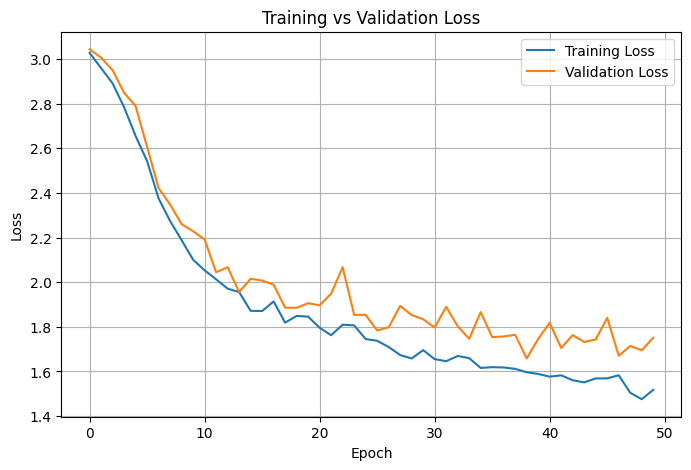

In [92]:
# Create an instance of the MLP model
mlp_model = MLP()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer for the MLP model
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.0001)

print("\nTraining MLP...")
# Train the MLP model and store the loss values
train_losses, val_losses = train_model(mlp_model, train_loader, valid_loader, criterion, optimizer_mlp, device, num_epochs=50)

print("Evaluating MLP on test set:")
# Evaluate the MLP model on the test set
evaluate_model(mlp_model, test_loader, device)

# Plot the training loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Training CNN...
Epoch 1/50, Train Loss: 2.7306, Val Loss: 2.8812
Epoch 2/50, Train Loss: 1.7859, Val Loss: 2.1712
Epoch 3/50, Train Loss: 1.4317, Val Loss: 1.4612
Epoch 4/50, Train Loss: 1.1773, Val Loss: 1.1117
Epoch 5/50, Train Loss: 0.8997, Val Loss: 0.9618
Epoch 6/50, Train Loss: 0.7227, Val Loss: 0.8651
Epoch 7/50, Train Loss: 0.6284, Val Loss: 0.7734
Epoch 8/50, Train Loss: 0.5429, Val Loss: 0.7764
Epoch 9/50, Train Loss: 0.4383, Val Loss: 0.6723
Epoch 10/50, Train Loss: 0.3909, Val Loss: 0.7078
Epoch 11/50, Train Loss: 0.3543, Val Loss: 0.7438
Epoch 12/50, Train Loss: 0.3177, Val Loss: 0.6661
Epoch 13/50, Train Loss: 0.2657, Val Loss: 0.6127
Epoch 14/50, Train Loss: 0.2422, Val Loss: 0.7101
Epoch 15/50, Train Loss: 0.2339, Val Loss: 0.6068
Epoch 16/50, Train Loss: 0.2181, Val Loss: 0.5688
Epoch 17/50, Train Loss: 0.1572, Val Loss: 0.5517
Epoch 18/50, Train Loss: 0.1486, Val Loss: 0.5924
Epoch 19/50, Train Loss: 0.1929, Val Loss: 0.6596
Epoch 20/50, Train Loss: 0.1370, Val Loss:

,precision,recall,f1-score,support
0,1.000000,0.625000,0.769231,8.00000
1,0.666667,0.666667,0.666667,3.00000
2,0.750000,1.000000,0.857143,3.00000
3,0.500000,1.000000,0.666667,1.00000
4,0.500000,1.000000,0.666667,2.00000
5,0.500000,0.250000,0.333333,4.00000
6,0.833333,1.000000,0.909091,5.00000
7,0.666667,0.666667,0.666667,6.00000
8,0.833333,0.625000,0.714286,8.00000
9,0.200000,0.333333,0.250000,3.00000


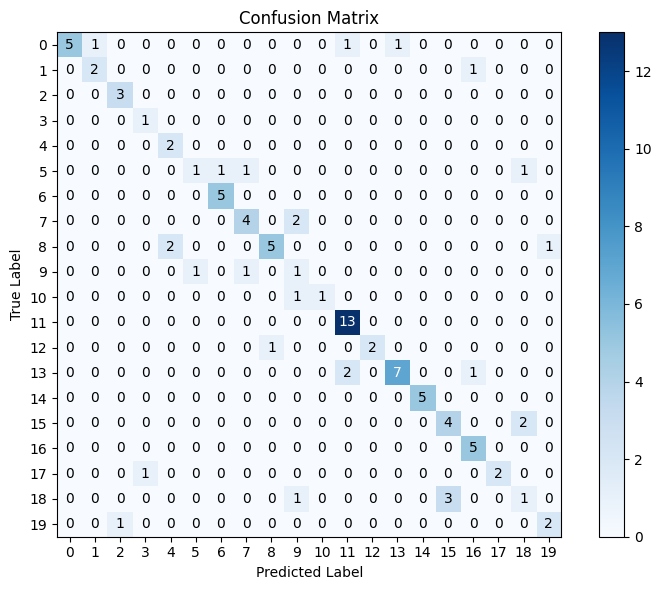

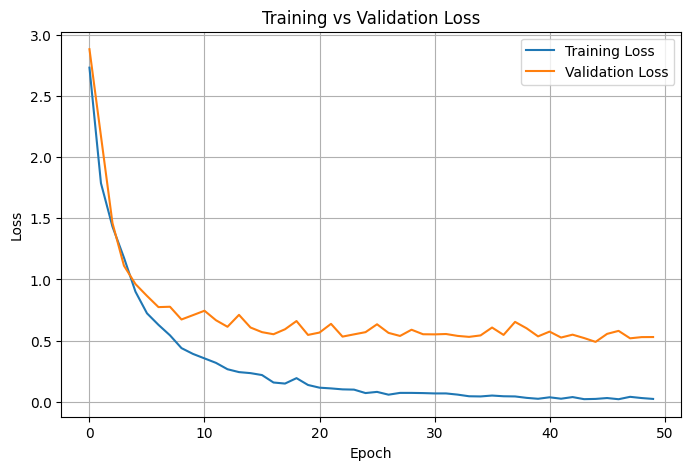

In [93]:
# Create an instance of the SimpleCNN model
cnn_model = SimpleCNN()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer for the CNN model
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.0001)

print("\nTraining CNN...")
# Train the CNN model and store the loss values
train_losses, val_losses = train_model(cnn_model, train_loader, valid_loader, criterion, optimizer_cnn, device, num_epochs=50)

print("Evaluating CNN on test set:")
# Evaluate the CNN model on the test set
evaluate_model(cnn_model, test_loader, device)

# Plot the training loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Question 1 [5pts]

What are the main advantages of CNNs over MLPs in image processing, and how do they improve performance?

CNNs overperform MLPs in image processing since CNNs have the capability of capturing the spatial nature of images thanks to the existence of convolutional layers that learn these spatial features. Different to MLPs, CNNs detect meaningful patterns like edges, textures and shapes at various levels of abstraction where MLPs flatten images and ignore these spatial structures. The use of shared weights in the filters of CNN reduces the number of total parameters and enhances generalization. CNNs also introduce pooling layers that reduces the size of feature maps by summarizing small regions that help the model focus on the most valuable information while reducing the amount of data to process. Together, convolution and pooling layers help CNNs recognize objects even if they appear in different parts of the image. This structure makes CNNs more efficient and accurate than MLPs, especially when dealing with high-resolution images, while also using fewer parameters and avoiding overfitting.



# Hyperparameter Tunining [10pts]
In this part of the assignment, you are expected to define and train multiple versions of your model using different hyperparameters (e.g., learning rate, batch size, number of epochs, optimizer type).
Hint: set learning rate within the range of 0.00001 to 0.01

**Note:** Make sure you should use at least 3 different configurations for each model. If you change the number of layers, make sure to send the version that is defined in the description.


Training MLP...
Epoch 1/50, Train Loss: 4.2634, Val Loss: 3.0726
Epoch 2/50, Train Loss: 3.0644, Val Loss: 3.1208
Epoch 3/50, Train Loss: 2.9754, Val Loss: 3.0162
Epoch 4/50, Train Loss: 2.9366, Val Loss: 2.9741
Epoch 5/50, Train Loss: 2.8195, Val Loss: 2.8280
Epoch 6/50, Train Loss: 2.5286, Val Loss: 2.6446
Epoch 7/50, Train Loss: 2.3237, Val Loss: 2.4198
Epoch 8/50, Train Loss: 2.1156, Val Loss: 2.1891
Epoch 9/50, Train Loss: 2.0612, Val Loss: 2.0949
Epoch 10/50, Train Loss: 1.9443, Val Loss: 1.9588
Epoch 11/50, Train Loss: 1.8956, Val Loss: 1.9960
Epoch 12/50, Train Loss: 1.8908, Val Loss: 2.0418
Epoch 13/50, Train Loss: 1.9721, Val Loss: 1.8067
Epoch 14/50, Train Loss: 1.7504, Val Loss: 1.8650
Epoch 15/50, Train Loss: 1.8571, Val Loss: 2.0053
Epoch 16/50, Train Loss: 1.8915, Val Loss: 1.9035
Epoch 17/50, Train Loss: 1.7621, Val Loss: 2.0031
Epoch 18/50, Train Loss: 1.8260, Val Loss: 1.8053
Epoch 19/50, Train Loss: 1.7897, Val Loss: 1.7410
Epoch 20/50, Train Loss: 1.7164, Val Loss:

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,8.000000
1,0.333333,0.666667,0.444444,3.000000
2,1.000000,1.000000,1.000000,3.000000
3,0.000000,0.000000,0.000000,1.000000
4,0.000000,0.000000,0.000000,2.000000
5,0.000000,0.000000,0.000000,4.000000
6,0.666667,0.400000,0.500000,5.000000
7,0.500000,0.166667,0.250000,6.000000
8,0.000000,0.000000,0.000000,8.000000
9,0.000000,0.000000,0.000000,3.000000


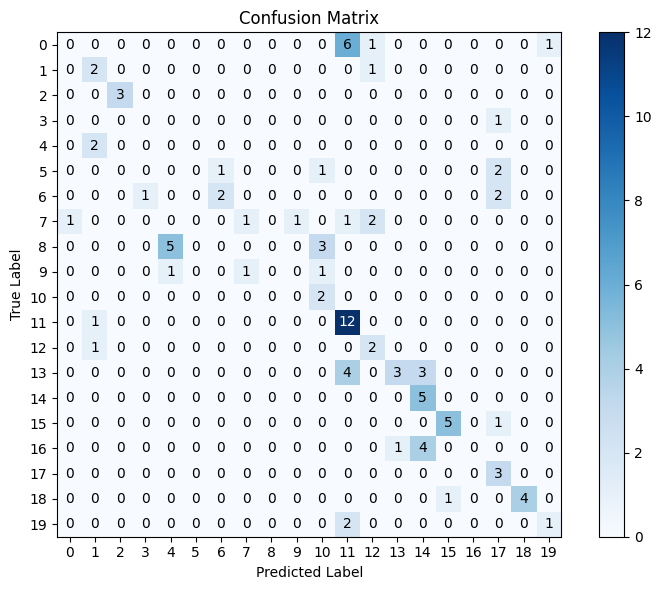

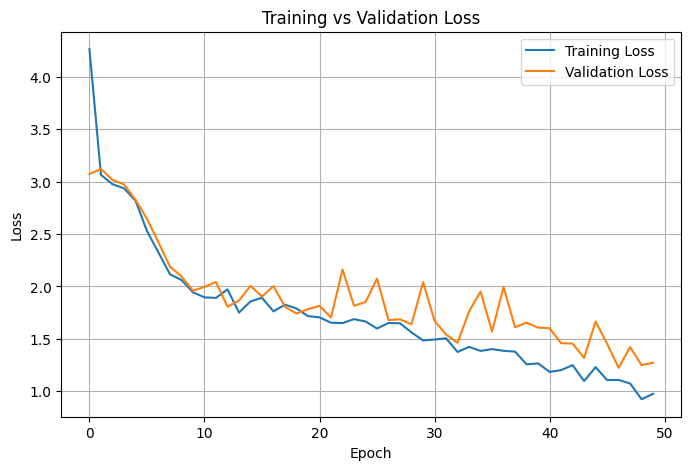

In [ ]:
# MLP Tuning:
# lr = 0.0001, optimizer = Adam, accuracy = 32.65%
# lr = 0.001, optimizer = Adam -> case 2
# lr = 0.001, optimizer = Adamax -> case 3
# lr = 0.001, optimizer = RMSprop -> case 4
# using the given code,



# lr = 0.001, optimizer = Adam, case 2
# Create an instance of the MLP model
mlp_model = MLP()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer for the MLP model
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)

print("\nTraining MLP...")
# Train the MLP model and store the loss values
train_losses, val_losses = train_model(mlp_model, train_loader, valid_loader, criterion, optimizer_mlp, device, num_epochs=50)

print("Evaluating MLP on test set:")
# Evaluate the MLP model on the test set
evaluate_model(mlp_model, test_loader, device)

# Plot the training loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



Training MLP...
Epoch 1/50, Train Loss: 4.3034, Val Loss: 3.1131
Epoch 2/50, Train Loss: 3.0051, Val Loss: 3.2215
Epoch 3/50, Train Loss: 2.9288, Val Loss: 3.0248
Epoch 4/50, Train Loss: 2.9008, Val Loss: 2.9582
Epoch 5/50, Train Loss: 2.7464, Val Loss: 2.7945
Epoch 6/50, Train Loss: 2.6379, Val Loss: 2.7768
Epoch 7/50, Train Loss: 2.5098, Val Loss: 2.6137
Epoch 8/50, Train Loss: 2.4073, Val Loss: 2.4350
Epoch 9/50, Train Loss: 2.2932, Val Loss: 2.3227
Epoch 10/50, Train Loss: 2.2045, Val Loss: 2.3403
Epoch 11/50, Train Loss: 2.1558, Val Loss: 2.1995
Epoch 12/50, Train Loss: 2.0906, Val Loss: 2.1455
Epoch 13/50, Train Loss: 2.0616, Val Loss: 2.0812
Epoch 14/50, Train Loss: 1.9672, Val Loss: 2.0751
Epoch 15/50, Train Loss: 1.9119, Val Loss: 1.9818
Epoch 16/50, Train Loss: 1.8923, Val Loss: 1.9293
Epoch 17/50, Train Loss: 1.8763, Val Loss: 2.0641
Epoch 18/50, Train Loss: 1.8822, Val Loss: 2.0022
Epoch 19/50, Train Loss: 1.9320, Val Loss: 2.0018
Epoch 20/50, Train Loss: 1.8369, Val Loss:

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,8.000000
1,0.666667,0.666667,0.666667,3.000000
2,0.000000,0.000000,0.000000,3.000000
3,0.083333,1.000000,0.153846,1.000000
4,0.166667,0.500000,0.250000,2.000000
5,0.000000,0.000000,0.000000,4.000000
6,1.000000,0.400000,0.571429,5.000000
7,0.000000,0.000000,0.000000,6.000000
8,0.428571,0.750000,0.545455,8.000000
9,0.000000,0.000000,0.000000,3.000000


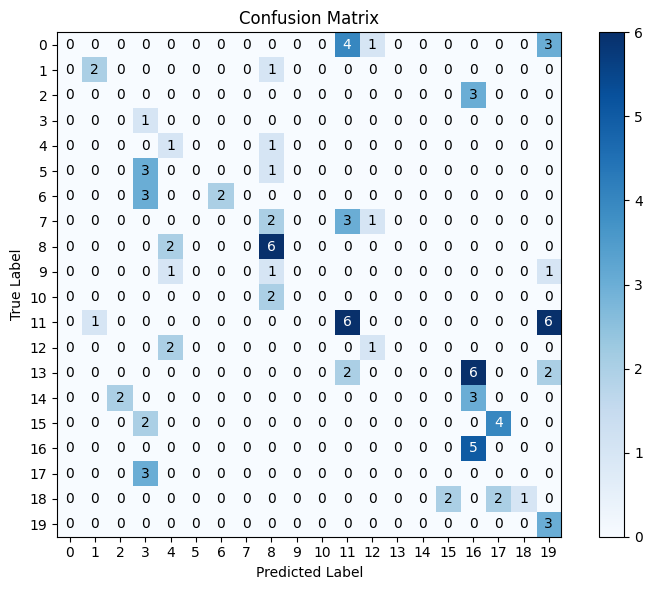

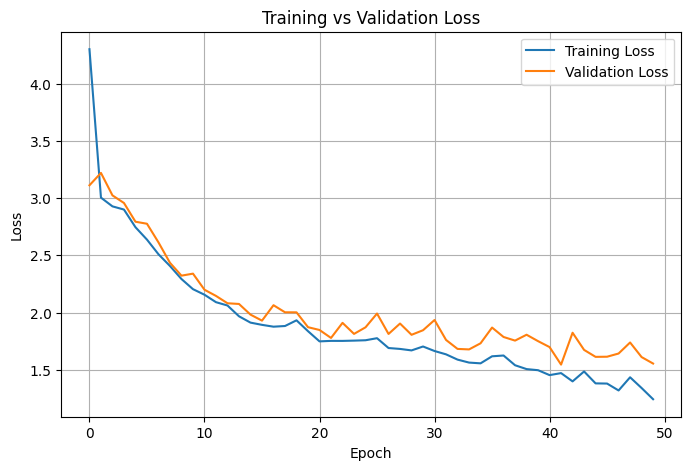

In [105]:
# lr = 0.001, optimizer = Adamax, case 3
# Create an instance of the MLP model
mlp_model = MLP()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer for the MLP model
optimizer_mlp = optim.Adamax(mlp_model.parameters(), lr=0.001)

print("\nTraining MLP...")
# Train the MLP model and store the loss values
train_losses, val_losses = train_model(mlp_model, train_loader, valid_loader, criterion, optimizer_mlp, device, num_epochs=50)

print("Evaluating MLP on test set:")
# Evaluate the MLP model on the test set
evaluate_model(mlp_model, test_loader, device)

# Plot the training loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Training MLP...
Epoch 1/50, Train Loss: 45.1078, Val Loss: 3.0411
Epoch 2/50, Train Loss: 3.0314, Val Loss: 3.0335
Epoch 3/50, Train Loss: 2.9781, Val Loss: 3.0710
Epoch 4/50, Train Loss: 2.9814, Val Loss: 2.9971
Epoch 5/50, Train Loss: 3.0146, Val Loss: 2.9671
Epoch 6/50, Train Loss: 3.7019, Val Loss: 2.9946
Epoch 7/50, Train Loss: 2.9911, Val Loss: 3.0158
Epoch 8/50, Train Loss: 2.9794, Val Loss: 3.0160
Epoch 9/50, Train Loss: 2.9742, Val Loss: 3.0337
Epoch 10/50, Train Loss: 2.9724, Val Loss: 3.0234
Epoch 11/50, Train Loss: 2.9638, Val Loss: 2.9924
Epoch 12/50, Train Loss: 2.9373, Val Loss: 2.9678
Epoch 13/50, Train Loss: 2.9509, Val Loss: 3.0089
Epoch 14/50, Train Loss: 2.9441, Val Loss: 2.9676
Epoch 15/50, Train Loss: 2.8634, Val Loss: 2.8972
Epoch 16/50, Train Loss: 2.7382, Val Loss: 4.3080
Epoch 17/50, Train Loss: 2.7270, Val Loss: 2.7423
Epoch 18/50, Train Loss: 2.5880, Val Loss: 2.7840
Epoch 19/50, Train Loss: 2.5136, Val Loss: 3.3202
Epoch 20/50, Train Loss: 2.6098, Val Loss

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,8.000000
1,0.000000,0.000000,0.000000,3.000000
2,0.000000,0.000000,0.000000,3.000000
3,0.000000,0.000000,0.000000,1.000000
4,0.000000,0.000000,0.000000,2.000000
5,0.000000,0.000000,0.000000,4.000000
6,0.000000,0.000000,0.000000,5.000000
7,0.000000,0.000000,0.000000,6.000000
8,0.000000,0.000000,0.000000,8.000000
9,0.000000,0.000000,0.000000,3.000000


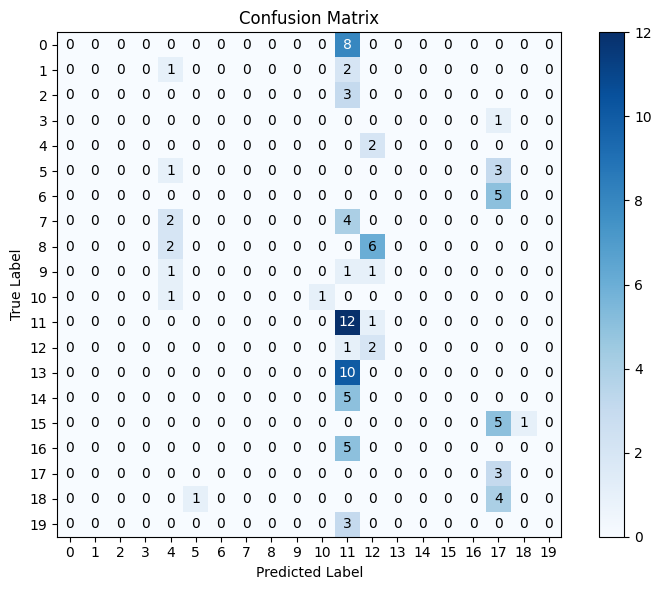

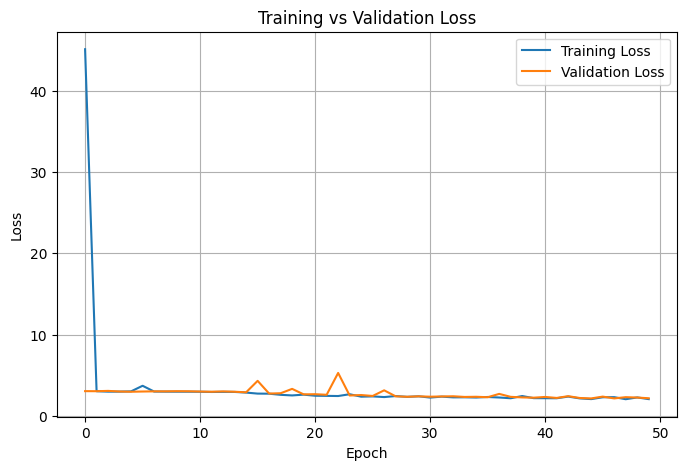

In [ ]:
# lr = 0.001, optimizer = RMSprop, case 4
# Create an instance of the MLP model
mlp_model = MLP()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer for the MLP model
optimizer_mlp = optim.RMSprop(mlp_model.parameters(), lr=0.001)

print("\nTraining MLP...")
# Train the MLP model and store the loss values
train_losses, val_losses = train_model(mlp_model, train_loader, valid_loader, criterion, optimizer_mlp, device, num_epochs=50)

print("Evaluating MLP on test set:")
# Evaluate the MLP model on the test set
evaluate_model(mlp_model, test_loader, device)

# Plot the training loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

MLP Tuning Results: <br>
lr = 0.0001, optimizer = Adam, accuracy = 32.65% <br>
lr = 0.001, optimizer = Adam, accuracy = 45.92% <br>
lr = 0.001, optimizer = Adamax, accuracy = 28.57% <br>
lr = 0.001, optimizer = RMSprop, accuracy = 18.37%


Training CNN...
Epoch 1/50, Train Loss: 4.8992, Val Loss: 2.9065
Epoch 2/50, Train Loss: 2.1318, Val Loss: 2.5084
Epoch 3/50, Train Loss: 1.7837, Val Loss: 1.6562
Epoch 4/50, Train Loss: 1.5388, Val Loss: 2.0647
Epoch 5/50, Train Loss: 1.3989, Val Loss: 1.2383
Epoch 6/50, Train Loss: 1.3137, Val Loss: 1.1917
Epoch 7/50, Train Loss: 1.0888, Val Loss: 3.7013
Epoch 8/50, Train Loss: 1.1345, Val Loss: 3.6141
Epoch 9/50, Train Loss: 1.0587, Val Loss: 0.8248
Epoch 10/50, Train Loss: 0.8791, Val Loss: 2.1949
Epoch 11/50, Train Loss: 0.8171, Val Loss: 1.8540
Epoch 12/50, Train Loss: 0.7360, Val Loss: 0.6130
Epoch 13/50, Train Loss: 0.7688, Val Loss: 1.2702
Epoch 14/50, Train Loss: 0.7333, Val Loss: 1.7407
Epoch 15/50, Train Loss: 0.6698, Val Loss: 1.0188
Epoch 16/50, Train Loss: 0.6324, Val Loss: 0.6874
Epoch 17/50, Train Loss: 0.6935, Val Loss: 0.7795
Epoch 18/50, Train Loss: 0.5476, Val Loss: 0.6391
Epoch 19/50, Train Loss: 0.5812, Val Loss: 1.0276
Epoch 20/50, Train Loss: 0.5586, Val Loss:

,precision,recall,f1-score,support
0,1.000000,0.875000,0.933333,8.000000
1,1.000000,0.333333,0.500000,3.000000
2,1.000000,1.000000,1.000000,3.000000
3,0.333333,1.000000,0.500000,1.000000
4,0.400000,1.000000,0.571429,2.000000
5,0.800000,1.000000,0.888889,4.000000
6,0.714286,1.000000,0.833333,5.000000
7,1.000000,0.666667,0.800000,6.000000
8,0.833333,0.625000,0.714286,8.000000
9,0.250000,0.333333,0.285714,3.000000


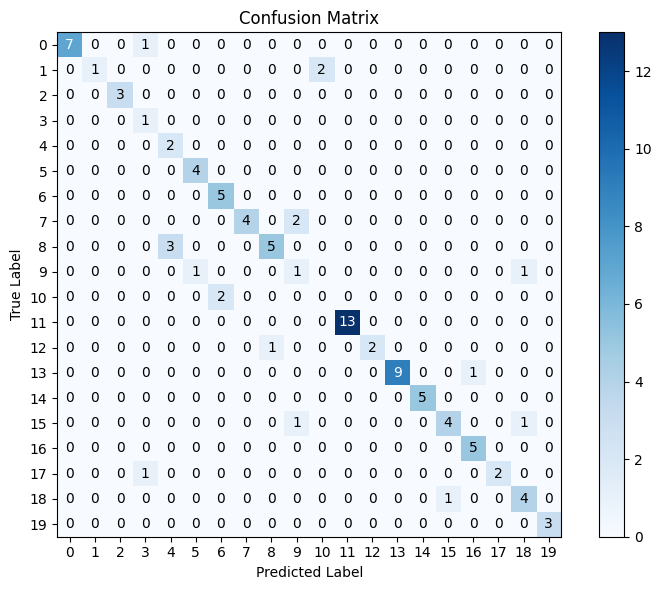

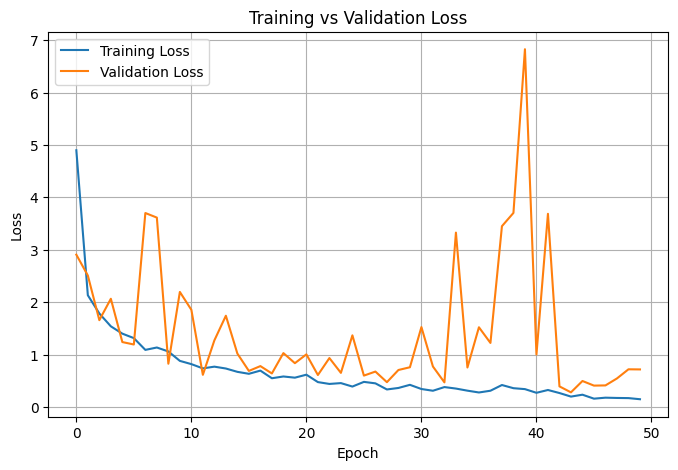

In [109]:
# CNN Tuning:
# lr = 0.0001, optimizer = Adam, accuracy = 72.45%
# lr = 0.001, optimizer = Adam -> case 2
# lr = 0.001, optimizer = Adamax -> case 3
# lr = 0.001, optimizer = RMSprop -> case 4
# using the given code,

# lr = 0.001, optimizer = Adam, case 2
# Create an instance of the SimpleCNN model
cnn_model = SimpleCNN()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer for the CNN model
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)

print("\nTraining CNN...")
# Train the CNN model and store the loss values
train_losses, val_losses = train_model(cnn_model, train_loader, valid_loader, criterion, optimizer_cnn, device, num_epochs=50)

print("Evaluating CNN on test set:")
# Evaluate the CNN model on the test set
evaluate_model(cnn_model, test_loader, device)

# Plot the training loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Training CNN...
Epoch 1/50, Train Loss: 5.5810, Val Loss: 3.2785
Epoch 2/50, Train Loss: 2.0574, Val Loss: 2.6093
Epoch 3/50, Train Loss: 1.7566, Val Loss: 1.7551
Epoch 4/50, Train Loss: 1.6109, Val Loss: 1.5560
Epoch 5/50, Train Loss: 1.4520, Val Loss: 1.3577
Epoch 6/50, Train Loss: 1.1899, Val Loss: 1.2726
Epoch 7/50, Train Loss: 1.2273, Val Loss: 1.0707
Epoch 8/50, Train Loss: 1.1666, Val Loss: 1.1149
Epoch 9/50, Train Loss: 0.8970, Val Loss: 0.9600
Epoch 10/50, Train Loss: 0.8091, Val Loss: 1.0501
Epoch 11/50, Train Loss: 0.7770, Val Loss: 0.8732
Epoch 12/50, Train Loss: 0.6568, Val Loss: 0.8272
Epoch 13/50, Train Loss: 0.6619, Val Loss: 0.8505
Epoch 14/50, Train Loss: 0.5819, Val Loss: 0.8736
Epoch 15/50, Train Loss: 0.5923, Val Loss: 0.8331
Epoch 16/50, Train Loss: 0.5866, Val Loss: 0.9162
Epoch 17/50, Train Loss: 0.4816, Val Loss: 0.7762
Epoch 18/50, Train Loss: 0.5341, Val Loss: 0.7222
Epoch 19/50, Train Loss: 0.3813, Val Loss: 0.6694
Epoch 20/50, Train Loss: 0.3851, Val Loss:

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

,precision,recall,f1-score,support
0,1.000000,0.750000,0.857143,8.000000
1,0.666667,0.666667,0.666667,3.000000
2,1.000000,1.000000,1.000000,3.000000
3,0.500000,1.000000,0.666667,1.000000
4,0.400000,1.000000,0.571429,2.000000
5,0.000000,0.000000,0.000000,4.000000
6,0.833333,1.000000,0.909091,5.000000
7,0.600000,0.500000,0.545455,6.000000
8,0.833333,0.625000,0.714286,8.000000
9,0.000000,0.000000,0.000000,3.000000


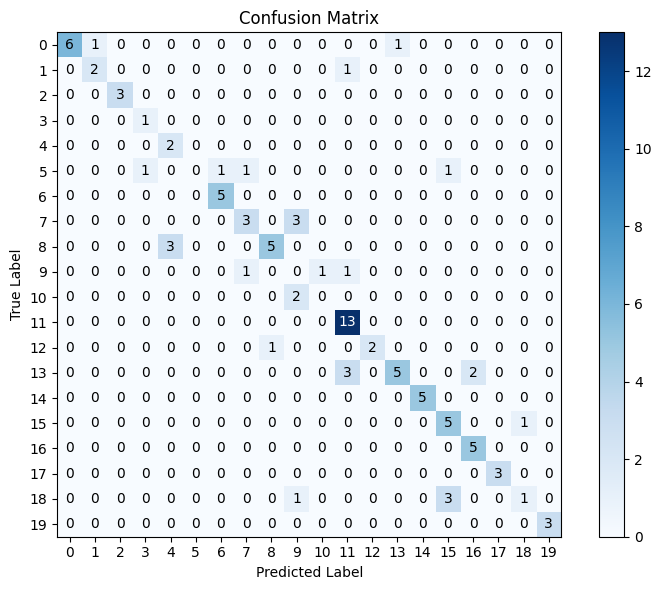

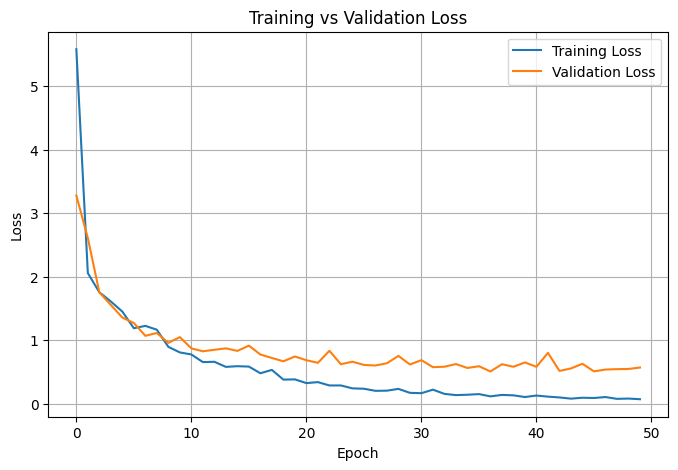

In [110]:
# lr = 0.001, optimizer = Adamax, case 3
# Create an instance of the SimpleCNN model
cnn_model = SimpleCNN()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer for the CNN model
optimizer_cnn = optim.Adamax(cnn_model.parameters(), lr=0.001)

print("\nTraining CNN...")
# Train the CNN model and store the loss values
train_losses, val_losses = train_model(cnn_model, train_loader, valid_loader, criterion, optimizer_cnn, device, num_epochs=50)

print("Evaluating CNN on test set:")
# Evaluate the CNN model on the test set
evaluate_model(cnn_model, test_loader, device)

# Plot the training loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Training CNN...
Epoch 1/50, Train Loss: 21.8464, Val Loss: 3.0661
Epoch 2/50, Train Loss: 2.7786, Val Loss: 3.2320
Epoch 3/50, Train Loss: 2.5545, Val Loss: 2.6517
Epoch 4/50, Train Loss: 2.1864, Val Loss: 2.0269
Epoch 5/50, Train Loss: 2.1315, Val Loss: 1.8168
Epoch 6/50, Train Loss: 1.9228, Val Loss: 2.2099
Epoch 7/50, Train Loss: 1.7241, Val Loss: 2.1370
Epoch 8/50, Train Loss: 1.7684, Val Loss: 1.7069
Epoch 9/50, Train Loss: 1.6384, Val Loss: 1.5861
Epoch 10/50, Train Loss: 1.5420, Val Loss: 1.4139
Epoch 11/50, Train Loss: 1.5248, Val Loss: 1.5850
Epoch 12/50, Train Loss: 1.5417, Val Loss: 2.8367
Epoch 13/50, Train Loss: 1.4958, Val Loss: 1.7680
Epoch 14/50, Train Loss: 1.5116, Val Loss: 1.8136
Epoch 15/50, Train Loss: 1.3686, Val Loss: 1.5700
Epoch 16/50, Train Loss: 1.2481, Val Loss: 1.4884
Epoch 17/50, Train Loss: 1.3564, Val Loss: 1.8591
Epoch 18/50, Train Loss: 1.2716, Val Loss: 1.9959
Epoch 19/50, Train Loss: 1.2198, Val Loss: 2.0943
Epoch 20/50, Train Loss: 1.0803, Val Loss

,precision,recall,f1-score,support
0,1.000000,0.625000,0.769231,8.000000
1,0.250000,0.333333,0.285714,3.000000
2,1.000000,1.000000,1.000000,3.000000
3,0.500000,1.000000,0.666667,1.000000
4,0.500000,1.000000,0.666667,2.000000
5,0.000000,0.000000,0.000000,4.000000
6,0.714286,1.000000,0.833333,5.000000
7,1.000000,0.500000,0.666667,6.000000
8,0.750000,0.750000,0.750000,8.000000
9,0.500000,0.666667,0.571429,3.000000


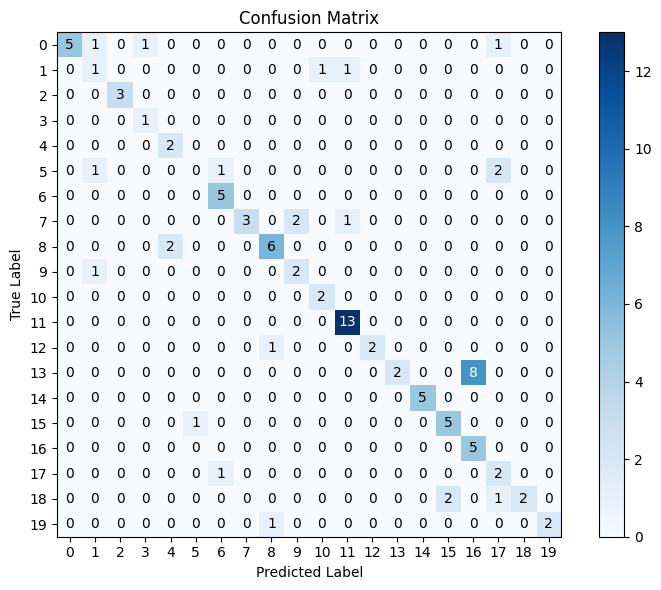

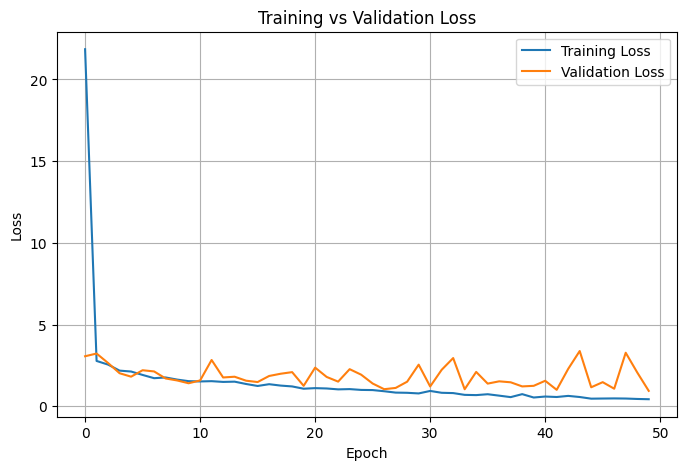

In [111]:
# lr = 0.001, optimizer = RMSprop, case 4
# Create an instance of the SimpleCNN model
cnn_model = SimpleCNN()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer for the CNN model
optimizer_cnn = optim.RMSprop(cnn_model.parameters(), lr=0.001)

print("\nTraining CNN...")
# Train the CNN model and store the loss values
train_losses, val_losses = train_model(cnn_model, train_loader, valid_loader, criterion, optimizer_cnn, device, num_epochs=50)

print("Evaluating CNN on test set:")
# Evaluate the CNN model on the test set
evaluate_model(cnn_model, test_loader, device)

# Plot the training loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

CNN Tuning Results: <br>
lr = 0.0001, optimizer = Adam, accuracy = 72.45% <br>
lr = 0.001, optimizer = Adam, accuracy = 81.63% <br>
lr = 0.001, optimizer = Adamax, accuracy = 70.41% <br>
lr = 0.01, optimizer = Adamax, accuracy = 69.39%

## Question 2 [5 pts]

Write a short summary of your observations on how the changes in hyperparameters affected the model's performance.

Both the learning rate and optimizer significantly influenced model performance, especially in terms of test accuracy. For the MLP, increasing the learning rate from 0.0001 to 0.001 with Adam led to a substantial accuracy boost (from 32.65% to 45.92%), showing that a moderate learning rate helps the model converge more effectively. However, using Adamax or RMSprop resulted in noticeably worse performance—especially with RMSprop, which led to severe overfitting or collapse, as the model predicted a single class too often. This suggests that MLPs are sensitive to both the optimizer type and step size, and Adam provided the most stable improvements.

For the CNN, Adam again gave the best results, reaching 81.63% accuracy at a 0.001 learning rate. This shows that CNNs can benefit from slightly higher learning rates when paired with a suitable optimizer. While Adamax also performed reasonably well (around 70%), increasing the learning rate further all the way to 0.01 slightly reduced its effectiveness, likely due to overly aggressive updates. Overall, Adam showed the most consistent performance across both models, and tuning the learning rate was crucial lower values worked better for the MLP initially, while CNNs handled slightly larger rates without destabilizing.

## Transfer Learning [25 pts]
Transfer learning is a technique where a model that has been pre-trained on a large dataset is adapted to a new, often smaller, dataset. In this approach, most of the layers of the pre-trained model are frozen, meaning their weights are not updated during training. These frozen layers already contain rich semantic information about general image features, such as edges, textures, and object parts.

To adapt the model to a specific task, the final layers are replaced to match the number of classes in the new dataset. Only these last few layers are trained, allowing the model to specialize in the new task while leveraging the general knowledge it has already learned. This method is efficient and avoids the computational cost of training a model from scratch. It also results in faster convergence and often better performance, especially when the new dataset is small.

Nowadays, large-scale pre-trained architectures that capture broad, universal representations, known as foundation models, are increasingly used to transfer knowledge across tasks. They offer better generalization to new problems compared to traditional approaches (See [here](https://medium.com/@tenyks_blogger/the-foundation-models-reshaping-computer-vision-b299a91527fb) for more details).

### Applying Transfer Learning to Egyptian Hieroglyphs Classification Task
We will apply transfer learning using a pre-trained ResNet18 model (for more information see [here](https://medium.com/swlh/resnet-a-simple-understanding-of-the-residual-networks-bfd8a1b4a447)). Since ResNet has already been trained on a large image dataset, it has learned to capture useful semantic features. We will:

1. **Prepare the data to match the input format expected by ResNet18.**

2. **Freeze the layers except layer 4 and the last layer to retain the learned features.**

3. **Replace the final layer to match the number of classes in our dataset.**

4. **Fine-tune the last layers to help the model adapt to the specifics of our task**

In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
# Load the data to match the input format expected by ResNet18.
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Mean and std normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
#Load datasets
train_dir = 'archive/train'
valid_dir = 'archive/valid'
test_dir  = 'archive/test'
train_dataset = ImageFolder(train_dir, transform=transform)
valid_dataset = ImageFolder(valid_dir, transform=transform)
test_dataset  = ImageFolder(test_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)
num_classes = len(train_dataset.classes)

#Load a pretrained ResNet18 model
transferred_model = models.resnet18(pretrained=True)

# Freeze all parameters except the last couple of layers (layer4 + fc)
#  By default, ResNet18 has named submodules: layer1, layer2, layer3, layer4, and fc.

for name, param in transferred_model.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False

#Replace the final fully connected layer to match the number of classes
in_features = transferred_model.fc.in_features
transferred_model.fc = nn.Linear(in_features, num_classes)

#Define loss function and optimizer.
# Hint: We only train the layer4 and fc layers so first get the params_to_update and pass params_to_update to the optimizer.
#Hint: set learning rate to 0.01 
params_to_update = [p for p in transferred_model.parameters() if p.requires_grad]
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=0.01)

#Print the model:
print(transferred_model)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  


Training...
Epoch 1/30, Train Loss: 2.4305, Val Loss: 2.4430
Epoch 2/30, Train Loss: 1.4218, Val Loss: 1.6516
Epoch 3/30, Train Loss: 0.9069, Val Loss: 1.1235
Epoch 4/30, Train Loss: 0.6162, Val Loss: 0.6847
Epoch 5/30, Train Loss: 0.4556, Val Loss: 0.4380
Epoch 6/30, Train Loss: 0.3267, Val Loss: 0.3533
Epoch 7/30, Train Loss: 0.2622, Val Loss: 0.3071
Epoch 8/30, Train Loss: 0.1995, Val Loss: 0.2644
Epoch 9/30, Train Loss: 0.1578, Val Loss: 0.2428
Epoch 10/30, Train Loss: 0.1420, Val Loss: 0.2179
Epoch 11/30, Train Loss: 0.1140, Val Loss: 0.1964
Epoch 12/30, Train Loss: 0.1189, Val Loss: 0.1662
Epoch 13/30, Train Loss: 0.0988, Val Loss: 0.1633
Epoch 14/30, Train Loss: 0.0848, Val Loss: 0.1572
Epoch 15/30, Train Loss: 0.0731, Val Loss: 0.1467
Epoch 16/30, Train Loss: 0.0720, Val Loss: 0.1427
Epoch 17/30, Train Loss: 0.0655, Val Loss: 0.1329
Epoch 18/30, Train Loss: 0.0527, Val Loss: 0.1339
Epoch 19/30, Train Loss: 0.0559, Val Loss: 0.1382
Epoch 20/30, Train Loss: 0.0452, Val Loss: 0.1

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,8.000000
1,1.000000,1.000000,1.000000,3.000000
2,1.000000,1.000000,1.000000,3.000000
3,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,2.000000
5,1.000000,1.000000,1.000000,4.000000
6,1.000000,1.000000,1.000000,5.000000
7,0.500000,0.166667,0.250000,6.000000
8,1.000000,1.000000,1.000000,8.000000
9,0.285714,0.666667,0.400000,3.000000


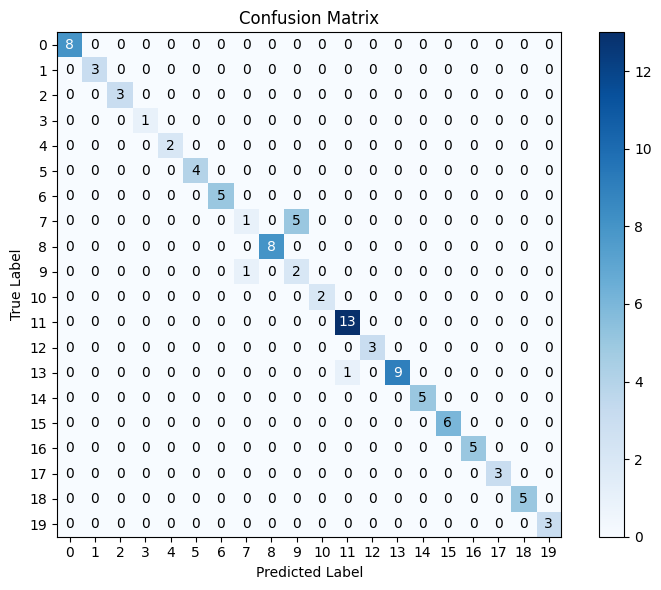

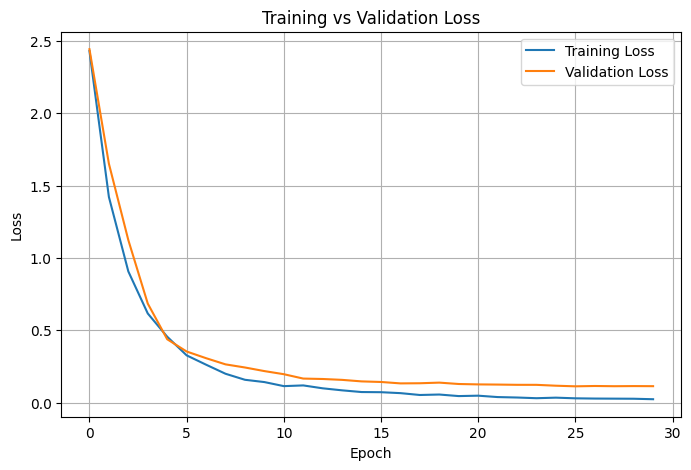

In [113]:
#Train and Evaluate the model. Provide the confusion matrix, presicion, recall, f1 and loss vs epoch plot as it is done for the previous models. 
#Hint: set learning rate to 0.01, and run for 30 epochs
print("\nTraining...")
train_losses, val_losses = train_model(transferred_model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=30)
evaluate_model(transferred_model, test_loader, device)

# Plot the training loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Question 3 [5pts]

How do the results of the different models compare, and what might explain the differences in their performance?

Across all three models being MLP, CNN, and fine-tuned ResNet18 there were clear performance differences driven by architectural design, training dynamics, and feature learning strategies. The MLP achieved the lowest test accuracy (45.92% at best), struggling with the image classification task due to its fully connected structure that flattens input and discards spatial relationships. As a result, it had to learn complex visual patterns from scratch, which limited both convergence and generalization.

The CNN showed a significant improvement with accuracies reaching up to 81.63%. By using convolutional layers and pooling, the CNN captured local features like edges and shapes while maintaining spatial hierarchies, allowing it to generalize better with fewer parameters and more stability. However, training it from scratch still left it vulnerable to issues like class imbalance and limited data diversity.

The best results came from the fine-tuned ResNet18, which achieved 92.86% accuracy. This model benefited from transfer learning, starting with pretrained filters that had already learned general visual features on a large dataset. Only a few layers were fine-tuned for the hieroglyph task, allowing for faster convergence, lower validation loss, and more balanced class-wise predictions. The ResNet18’s residual architecture also helped maintain strong gradient flow during training, leading to both stability and high performance. Overall, the increasing accuracy trend from MLP, CNN to ResNet18 reflects how inductive biases and prior knowledge from large scale data can significantly boost performance on specialized image classification tasks.